<a href="https://colab.research.google.com/github/kannavdhawan/fake_news_challenge/blob/master/CNN_LSTM_all_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing libraries/




In [37]:
  
import numpy as np
import pandas as pd
import os
import re
import csv
from IPython.display import Image
import pydot
from string import punctuation
import timeit

# gensim dependencies
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

# sklearn 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


# keras dependencies 
import keras
from keras.preprocessing.text import text_to_word_sequence as word_seq
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


from keras.models import Sequential, Model
from keras.layers import Input, Dense,  Activation, Bidirectional, LSTM, Embedding, Dropout, BatchNormalization,Conv1D,Flatten
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.utils import plot_model 
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model

from keras import optimizers
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints
from keras.callbacks import CSVLogger

import tensorflow as tf

import tensorflow as tf
tf.random.set_seed(1337)
# nltk 

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

%matplotlib inline
from matplotlib import pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Defining the hyperparameters of the neural network we are constructing

In [3]:
#Defining hyperparameters
trunc_1= 50     # maximum lenth to be padded
trunc_2= 100     # maximum lenth to be padded
trunc_3= 150     # maximum lenth to be padded
Dimensions_embedding_glove = 50   # as per glove, vector size 
seed = 1337 # reproducing the same results
np.random.seed(seed)   ### Using seed to get same results in every run

# Loading the train bodies and test bodies from the dataset

In [4]:
# loading the articles .csv files in dataset(both in train and competition set )


# loading body 
body_train = pd.read_csv('/content/drive/My Drive/fnc-1/'+'train_bodies.csv')
body_test = pd.read_csv('/content/drive/My Drive/fnc-1/'+'competition_test_bodies.csv')


### Loading the train stances and test stances from the dataset

# training data is being loaded(stances)
stances_train = pd.read_csv('/content/drive/My Drive/fnc-1/' + 'train_stances.csv')
# testing data is being loaded(stances)
stances_test = pd.read_csv('/content/drive/My Drive/fnc-1/'  + 'competition_test_stances.csv')

# checking 
print(body_train.tail(3))
print(body_test.tail(3))

      Body ID                                        articleBody
1680     2530  More than 200 schoolgirls were kidnapped in Ap...
1681     2531  A Guantanamo Bay prisoner released last year a...
1682     2532  ANN ARBOR, Mich. – A pizza delivery man in Mic...
     Body ID                                        articleBody
901     2584  Millions may lose coverage next year if Congre...
902     2585  Come November, the grim trudge across the incr...
903     2586  Remember how much Republicans wanted to repeal...


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
print("Checking dims  body train : ", body_train.shape)
print("Checking dims body test : ", body_test.shape)
print("Checking dims stances train : ", stances_train.shape)
print("Checking dims stances test: ", stances_test.shape)

Checking dims  body train :  (1683, 2)
Checking dims body test :  (904, 2)
Checking dims stances train :  (49972, 3)
Checking dims stances test:  (25413, 3)


In [6]:
stances_test.head()

,Headline,Body ID,Stance
0,Ferguson riots: Pregnant woman loses eye after...,2008,unrelated
1,Crazy Conservatives Are Sure a Gitmo Detainee ...,1550,unrelated
2,A Russian Guy Says His Justin Bieber Ringtone ...,2,unrelated
3,"Zombie Cat: Buried Kitty Believed Dead, Meows ...",1793,unrelated
4,Argentina's President Adopts Boy to End Werewo...,37,unrelated


### Replacing the stances with respective integer labels

In [7]:
def change_labels(stances_train,stances_test):
    # Replace the string stances with relative integer counterparts
    stances_train.replace('unrelated',1,True)
    stances_train.replace('agree',2,True)
    stances_train.replace('disagree',3,True)
    stances_train.replace('discuss',4,True)

    stances_test.replace('unrelated',1,True)
    stances_test.replace('agree',2,True)
    stances_test.replace('disagree',3,True)
    stances_test.replace('discuss',4,True)
    return stances_train,stances_test

In [8]:
stances_train,stances_test=change_labels(stances_train,stances_test)

stances_test.head()

,Headline,Body ID,Stance
0,Ferguson riots: Pregnant woman loses eye after...,2008,1
1,Crazy Conservatives Are Sure a Gitmo Detainee ...,1550,1
2,A Russian Guy Says His Justin Bieber Ringtone ...,2,1
3,"Zombie Cat: Buried Kitty Believed Dead, Meows ...",1793,1
4,Argentina's President Adopts Boy to End Werewo...,37,1


### Making the combined training and testing dataframes  using dataframe.join ()method

In [9]:
# combine bodies dataframe with stances dataframe for both train and competition test set
full_train = stances_train.join(body_train.set_index('Body ID'), on='Body ID')
full_test = stances_test.join(body_test.set_index('Body ID'), on='Body ID')

In [10]:
print(full_train.shape)
print(full_test.shape)

(49972, 4)
(25413, 4)


In [11]:
full_train.head(3)

,Headline,Body ID,Stance,articleBody
0,Police find mass graves with at least '15 bodi...,712,1,Danny Boyle is directing the untitled film\n\n...
1,Hundreds of Palestinians flee floods in Gaza a...,158,2,Hundreds of Palestinians were evacuated from t...
2,"Christian Bale passes on role of Steve Jobs, a...",137,1,30-year-old Moscow resident was hospitalized w...


In [12]:
print("Unique body ids in final df :",len(full_train['Body ID'].unique()))

Unique body ids in final df : 1683


In [13]:
full_train.head(5)

,Headline,Body ID,Stance,articleBody
0,Police find mass graves with at least '15 bodi...,712,1,Danny Boyle is directing the untitled film\n\n...
1,Hundreds of Palestinians flee floods in Gaza a...,158,2,Hundreds of Palestinians were evacuated from t...
2,"Christian Bale passes on role of Steve Jobs, a...",137,1,30-year-old Moscow resident was hospitalized w...
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,1,(Reuters) - A Canadian soldier was shot at the...
4,Spider burrowed through tourist's stomach and ...,1923,3,"Fear not arachnophobes, the story of Bunbury's..."


### Here we are constructing text_to_word_sequence using keras function to form List of lists of  tokenized headlines for both train and test headings and bodies(articles)

In [14]:
# Here we are constructing text_to_word_sequence(keras functions)(Lists of lists)
def gen_tokens(dataset):
    headline = [word_seq(headline) for headline in dataset['Headline']]
    body = [word_seq(body) for body in dataset['articleBody']]
    return headline, body 

In [15]:
tokens_headline_train, tokens_body_train=gen_tokens(full_train)
tokens_headline_test, tokens_body_test=gen_tokens(full_test)

print(tokens_headline_train[0])
print(len(tokens_headline_train))

['police', 'find', 'mass', 'graves', 'with', 'at', 'least', "'15", "bodies'", 'near', 'mexico', 'town', 'where', '43', 'students', 'disappeared', 'after', 'police', 'clash']
49972


###  Adding all the train sequences together

In [16]:
def gen_data_for_fit_on_texts(tokens_headline_train,tokens_body_train):
    sequences= []
    for i in range(len(tokens_headline_train)):
        sequences.append(tokens_headline_train[i])
    for i in range(len(tokens_body_train)):
        sequences.append(tokens_body_train[i])
    return sequences

In [17]:
sequences=gen_data_for_fit_on_texts(tokens_headline_train,tokens_body_train)
sequences[0]  # headline form train set 

['police',
 'find',
 'mass',
 'graves',
 'with',
 'at',
 'least',
 "'15",
 "bodies'",
 'near',
 'mexico',
 'town',
 'where',
 '43',
 'students',
 'disappeared',
 'after',
 'police',
 'clash']

### Construct the keras tokenizer and apply fit on text function of it on word sequences generated

In [18]:
def gen_tokenize(sequences):
    # using keras tokenizer and filter_list
    tokenizer = Tokenizer(filters= '!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
    tokenizer.fit_on_texts([seq for seq in sequences])

    print("vocabulary size :", len(tokenizer.word_index))
    return tokenizer

In [19]:
tokenizer=gen_tokenize(sequences)

vocabulary size : 27873


### list of list of tokens
- tokens_headline_train
- tokens_body_train
- tokens_headline_test 
- tokens_body_test

In [20]:
def concat_head_body(headline,body):
    #Here we are combining headlines and bodies together
    combined_head_body=[]
    
    combined_head_body = [list(i) for i in headline]
    for i in range(len(headline)):
        # extend() modifies the original list and does not return any value
        combined_head_body[i].extend(body[i]) 
    return combined_head_body

In [21]:
combined_head_body_train=concat_head_body(tokens_headline_train,tokens_body_train)
combined_head_body_test=concat_head_body(tokens_headline_test,tokens_body_test)

In [22]:
# combined_head_body_train[0]

In [23]:
print(len(combined_head_body_train))
print(len(combined_head_body_train[0]))     # diffent length 
print(len(combined_head_body_train[1]))     # different length

49972
216
445


### Using keras tokenizer for text to sequence and pad sequence generation for train dataset and test dataset
### Forming train labels  for the combined train data frame

In [24]:
def generate_padded_dataset(combined_head_body,tokenizer,df,trunc_n):
    # Now we will take max length to lower the length of sentences we have to deal with. 
    #It is very important beacuse as the length of sentences increases, our ability to handle many of those senetences decreases
    # Convert the sequence of words to sequnce of indices
    # maximum length is trunc_n ..
    X = tokenizer.texts_to_sequences([' '.join(seq[:]) for seq in combined_head_body])
    X = pad_sequences(X, maxlen=trunc_n, padding='post', truncating='post')
    #target label from combined data frame
    y = df['Stance']
    return X, y

###  Embedding matrix using glove and the word_index dict


### Defining the data directory where we have  train and test dataset 
### Defing the path where we have GloVe pretrained embedding 

In [25]:
# Twitter glove with 50d
# converting the glove to word2vec 
glove2word2vec('/content/drive/My Drive/fnc-1/glove.6B.50d.txt', '/content/drive/My Drive/fnc-1/glove.50d.txt.word2vec')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


(400000, 50)

###  Here we are creating embedding matrix using our vocabulary we calculated. If the word is not in the GloVe, we take its vector as comprised of zeros

In [26]:
# embeddings
w2v_vectors= gensim.models.KeyedVectors.load_word2vec_format('/content/drive/My Drive/fnc-1/glove.50d.txt.word2vec', binary=False)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [27]:
w2v_vectors['the'].shape

(50,)

In [28]:
# Here we are creating embedding matrix using our vocabulary we calculated. If the word is not in the GloVe, we take its vector as comprised of zeros

found_count =0
not_found_count = 0
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, Dimensions_embedding_glove))
for word, i in tokenizer.word_index.items():
    try:
        e_vector= w2v_vectors[word]
    except KeyError:
        e_vector=None
    if e_vector is not None:          # If word exists in the Glove embedding we are using

        embedding_matrix[i] = e_vector
        found_count+=1
    else:
        not_found_count+=1

In [29]:
print("Found_count:",found_count)
print("Not found count:",not_found_count)

Found_count: 21092
Not found count: 6781


In [30]:
def plots(model,title_name,fig_name_acc,fig_name_loss):
    # Epoch vs Accuracy Plot
    # Epoch vs loss plot
    plt.figure(figsize=(8,7))
    plt.plot(model.history['accuracy'])
    plt.plot(model.history['val_accuracy'])
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.title(title_name)
    plt.legend(['Train accuracy', 'Val accuracy'])
    plt.savefig(fig_name_acc)
    plt.show()

    plt.figure(figsize=(8,7))
    plt.plot(model.history['loss'])
    plt.plot(model.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title(title_name)
    plt.legend(['Train Loss', 'Val Loss'])
    plt.savefig(fig_name_loss)
    plt.show()

In [31]:
def pred(features,target,model,csv_name):
    y_pred= model.predict(features)
    y_pred= [np.argmax(pred, axis = -1) for pred in y_pred]   # categorical to single
    y_test= [np.argmax(t, axis = -1) for t in target]             # cat to sin
    
    def change_labels(y):
      # change the labels back to original categories
        for i in range(len(y)): 
            if y[i] == 0:
                y[i] = "unrelated"
            if y[i] == 1:
                y[i] = "disagree"
            if y[i] == 2:
                y[i] = "agree"
            if y[i] == 3:
                y[i] = "discuss"
        return y
    y_pred=change_labels(y_pred)
    y_test=change_labels(y_test)

    stance_list = y_pred

    stances_test = pd.read_csv('/content/drive/My Drive/fnc-1/'  + 'competition_test_stances.csv',index_col=False)
    df=stances_test.drop(['Stance'],axis=1)
    df['Stance']=stance_list
    df=df[['Headline','Body ID','Stance']]
    df.to_csv(csv_name,index=False)
    return df

### Set1: 
- trunc_1=50

### Set2: 
- trunc_2=100

### Set3: 
- trunc_3=150

In [32]:
# keras.backend.clear_session()
# del cnn
# del model
# del model2

[[  90  407  712 ...    1 5602  490]
 [1060    4 9286 ...  617    4 2297]
 [ 639  464 7035 ...    1 4844    6]
 ...
 [ 735  110  210 ...    0    0    0]
 [  93 5578 1650 ... 3079    1 7688]
 [ 259  241    5 ... 3327  196   44]]
X_train.shape (49972, 50)
y_train.shape (49972,)
X_test.shape (25413, 50)
y_test.shape (25413,)
y_test shape:  (25413, 4)
X_train.shape (44974, 50)
y_train.shape (44974, 4)
X_val.shape (4998, 50)
y_val.shape (4998, 4)
X_test.shape (25413, 50)
y_test.shape (25413, 4)
***************************************CNN at truncation=  50
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_embedding_layer (Embedd (None, 50, 50)            1393700   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 32)            4832      
_________________________________________________________________
flatten_1 (Flatten)      

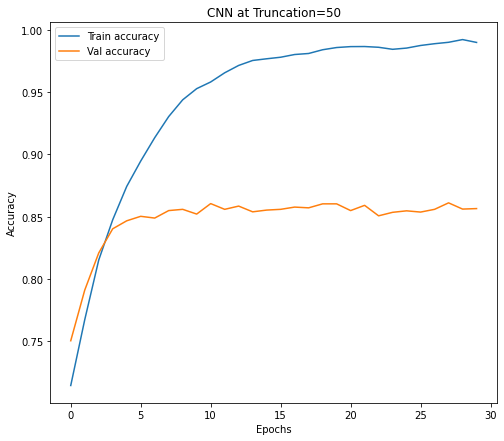

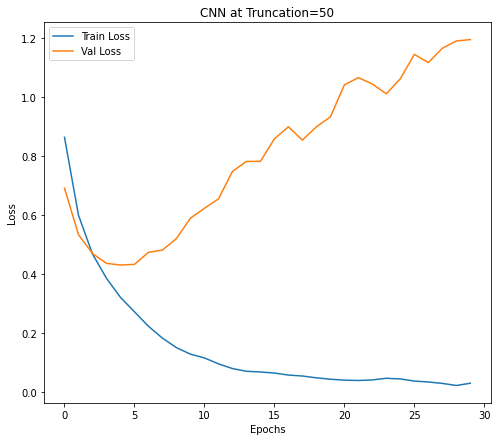

25413/25413 [==============================] - 2s 63us/step
Accuracy at test set for CNN at truncation = 50  is:  66.69421195983887
***************************************Bidirectional Lstm at truncation=  50
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_embedding_layer (Embedd (None, None, 50)          1393700   
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 256)         183296    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               164352    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
Dense_layer (Dense)          (None, 32)                4128      
___________________________________________

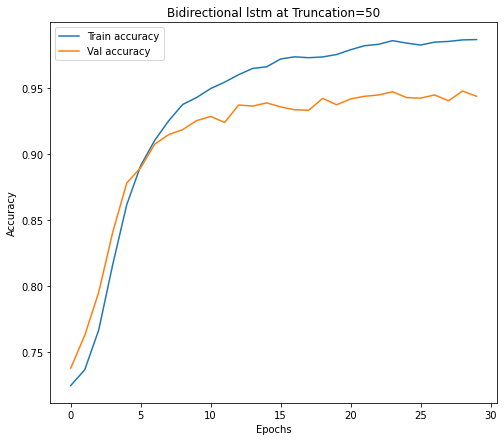

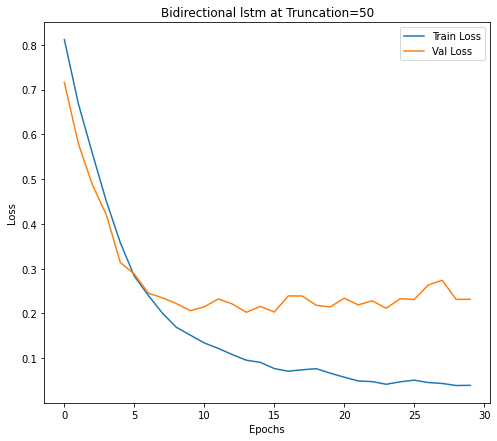

25413/25413 [==============================] - 26s 1ms/step
Accuracy at test set for Bidirectional Lstm at truncation = 50  is:  72.29764461517334
*************************************** Lstm at truncation=  50
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_embedding_layer (Embedd (None, None, 50)          1393700   
_________________________________________________________________
lstm_layer_1 (LSTM)          (None, None, 128)         91648     
_________________________________________________________________
lstm_layer_2 (LSTM)          (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
Dense_layer (Dense)          (None, 32)                2080      
_________________________________________

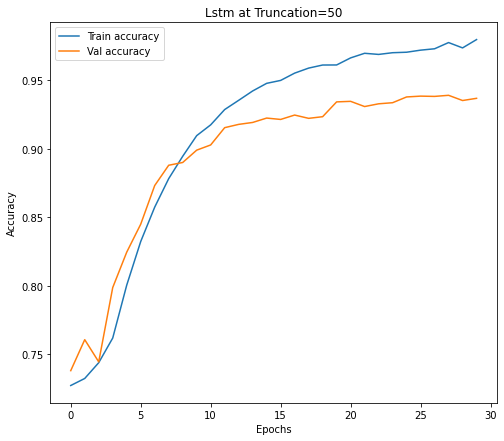

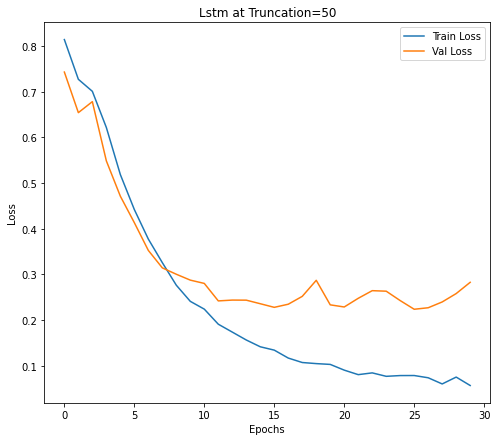

25413/25413 [==============================] - 14s 562us/step
Accuracy at test set for Lstm at truncation = 50  is:  71.34931087493896
[[  90  407  712 ...  578 2496   91]
 [1060    4 9286 ...    5  323  211]
 [ 639  464 7035 ...  123   25 2040]
 ...
 [ 735  110  210 ...    0    0    0]
 [  93 5578 1650 ...  502   10    1]
 [ 259  241    5 ...   76   52 5603]]
X_train.shape (49972, 100)
y_train.shape (49972,)
X_test.shape (25413, 100)
y_test.shape (25413,)
y_test shape:  (25413, 4)
X_train.shape (44974, 100)
y_train.shape (44974, 4)
X_val.shape (4998, 100)
y_val.shape (4998, 4)
X_test.shape (25413, 100)
y_test.shape (25413, 4)
***************************************CNN at truncation=  100
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_embedding_layer (Embedd (None, 100, 50)           1393700   
_________________________________________________________________
conv1d_1 (Conv1D

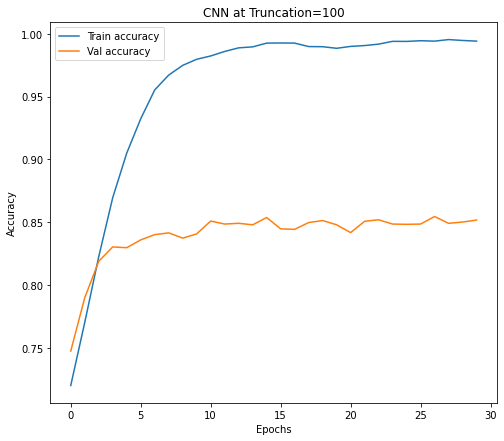

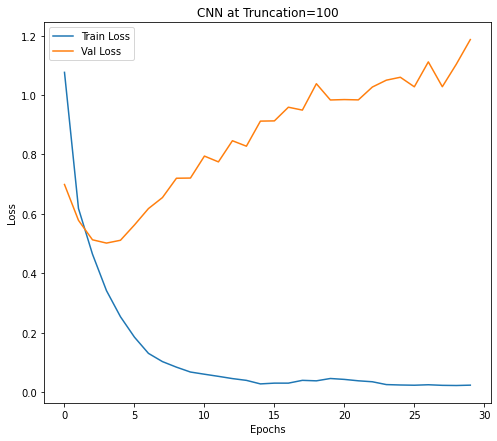

25413/25413 [==============================] - 2s 59us/step
Accuracy at test set for CNN at truncation = 100  is:  68.65383982658386
***************************************Bidirectional Lstm at truncation=  100
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_embedding_layer (Embedd (None, None, 50)          1393700   
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 256)         183296    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               164352    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
Dense_layer (Dense)          (None, 32)                4128      
_________________________________________

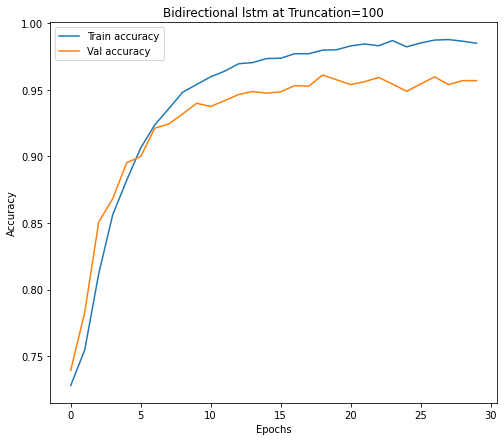

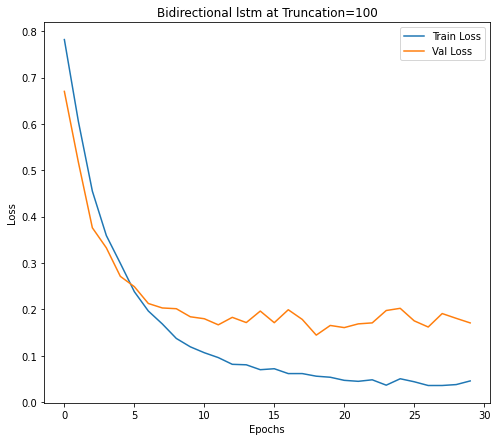

25413/25413 [==============================] - 52s 2ms/step
Accuracy at test set for Bidirectional Lstm at truncation = 100  is:  73.88344407081604
*************************************** Lstm at truncation=  100
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_embedding_layer (Embedd (None, None, 50)          1393700   
_________________________________________________________________
lstm_layer_1 (LSTM)          (None, None, 128)         91648     
_________________________________________________________________
lstm_layer_2 (LSTM)          (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
Dense_layer (Dense)          (None, 32)                2080      
_______________________________________

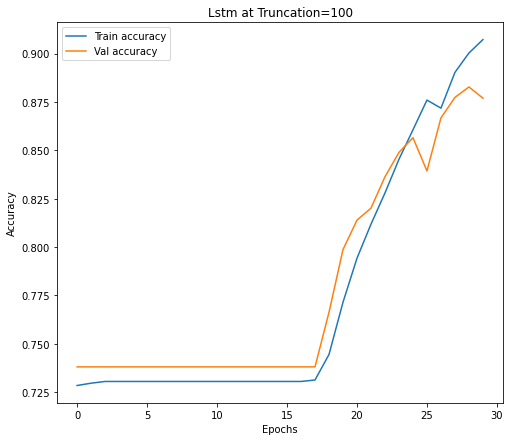

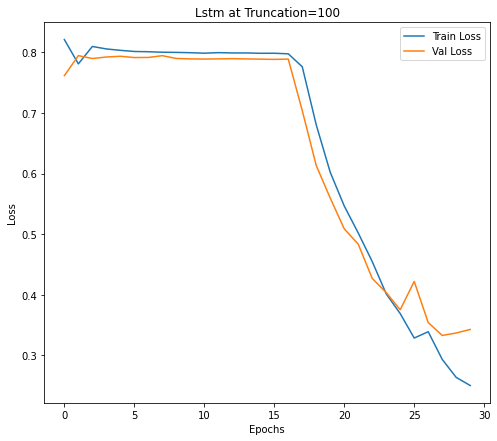

25413/25413 [==============================] - 27s 1ms/step
Accuracy at test set for Lstm at truncation = 100  is:  67.72518157958984
[[   90   407   712 ...  1800  5515   130]
 [ 1060     4  9286 ...     7   991    20]
 [  639   464  7035 ...    16  2225 10348]
 ...
 [  735   110   210 ...     0     0     0]
 [   93  5578  1650 ...     0     0     0]
 [  259   241     5 ...    15   354     1]]
X_train.shape (49972, 150)
y_train.shape (49972,)
X_test.shape (25413, 150)
y_test.shape (25413,)
y_test shape:  (25413, 4)
X_train.shape (44974, 150)
y_train.shape (44974, 4)
X_val.shape (4998, 150)
y_val.shape (4998, 4)
X_test.shape (25413, 150)
y_test.shape (25413, 4)
***************************************CNN at truncation=  150
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_embedding_layer (Embedd (None, 150, 50)           1393700   
_______________________________________________

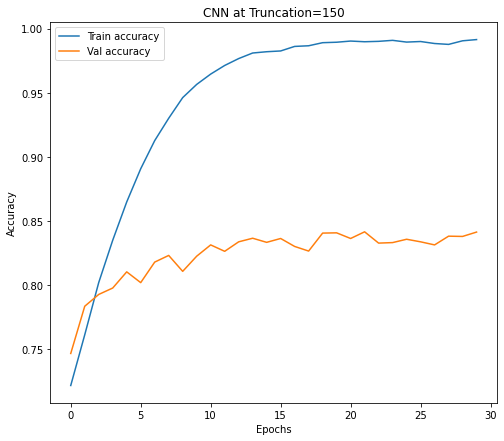

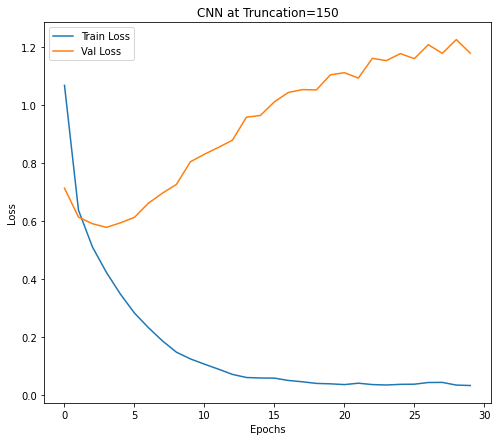

25413/25413 [==============================] - 2s 80us/step
Accuracy at test set for CNN at truncation = 150  is:  64.66375589370728
***************************************Bidirectional Lstm at truncation=  150
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_embedding_layer (Embedd (None, None, 50)          1393700   
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 256)         183296    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               164352    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
Dense_layer (Dense)          (None, 32)                4128      
_________________________________________

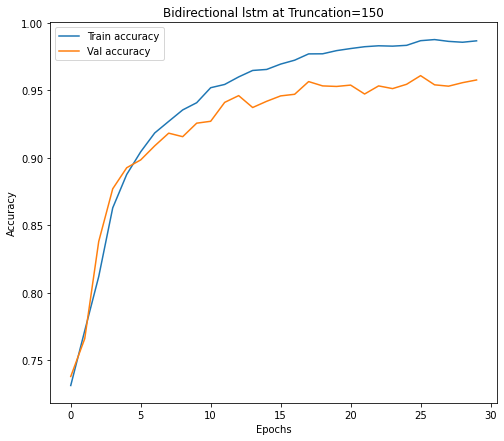

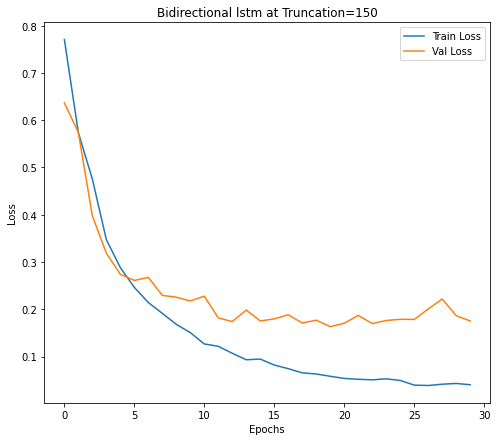

25413/25413 [==============================] - 75s 3ms/step
Accuracy at test set for Bidirectional Lstm at truncation = 150  is:  73.17514419555664
*************************************** Lstm at truncation=  150
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_embedding_layer (Embedd (None, None, 50)          1393700   
_________________________________________________________________
lstm_layer_1 (LSTM)          (None, None, 128)         91648     
_________________________________________________________________
lstm_layer_2 (LSTM)          (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
Dense_layer (Dense)          (None, 32)                2080      
_______________________________________

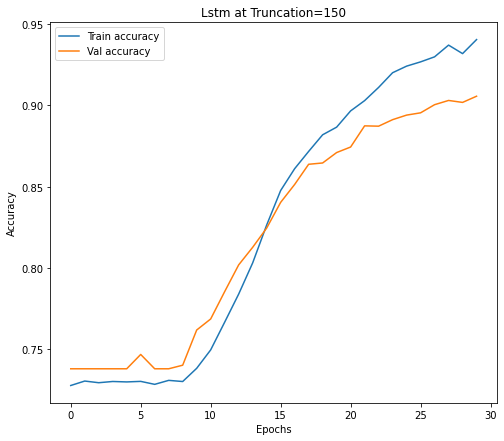

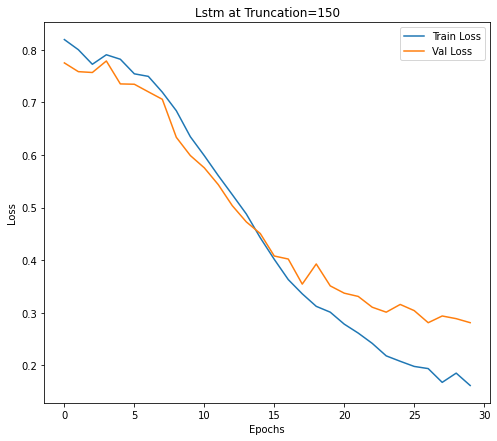

25413/25413 [==============================] - 37s 1ms/step
Accuracy at test set for Lstm at truncation = 150  is:  67.50088334083557


In [33]:
for trunc_n in [trunc_1,trunc_2,trunc_3]:
    
    X_train,y_train=generate_padded_dataset(combined_head_body_train,tokenizer,full_train,trunc_n)
    X_test,y_test=generate_padded_dataset(combined_head_body_test,tokenizer,full_test,trunc_n)
    print(X_train)
    print("X_train.shape",X_train.shape)
    print("y_train.shape",y_train.shape)
    print("X_test.shape",X_test.shape)
    print("y_test.shape",y_test.shape)
# Encoding the training labels and test labels and then converting them into one-hot-encoding form
   
    # Encoding labels(train)
    # Label Encoder is used to normalize the labels between 0 and N-Classes-1
    train_encoder = LabelEncoder()
    y_train_encoded=train_encoder.fit_transform(y_train)
    # Converting labels to one-hot-encoding
    y_train = np_utils.to_categorical(y_train_encoded)

    # # Encoding labels(test)
    # Label Encoder is used to normalize the labels between 0 and N-Classes-1
    test_encoder = LabelEncoder()# predefined function taken from sklearn
    y_test_encoded=test_encoder.fit_transform(y_test)
    y_test = np_utils.to_categorical(y_test_encoded)
    print("y_test shape: ",y_test.shape)
# splitting the dataset
    X_train, X_val, y_train, y_val= train_test_split(X_train,y_train, random_state=42, test_size=0.1)

    print("X_train.shape",X_train.shape)
    print("y_train.shape",y_train.shape)
    print("X_val.shape",X_val.shape)
    print("y_val.shape",y_val.shape)
    print("X_test.shape",X_test.shape)
    print("y_test.shape",y_test.shape)




    """
    Models | Bi lstm | Lstm | CNN

    """

    # CNN 
    print("***************************************CNN at truncation= ",trunc_n)

    cnn = Sequential()
    cnn.add(Embedding(input_dim=len(tokenizer.word_index)+1,output_dim=Dimensions_embedding_glove,
                              weights = [embedding_matrix], trainable=False,input_length = trunc_n, name='word_embedding_layer')) # trainable=True results in overfitting
 
    #Con1D layer is taken with 32 filters for feature extraction. 
    cnn.add(Conv1D(32, 3, padding='same', activation='relu'))

    cnn.add(Flatten())        #Flattened for Dense layer

    cnn.add(Dense(256, activation = 'relu'))  #A dense layer with 512 units and relu as activation. 

    cnn.add(Dense(4,activation ='softmax'))   #A final fully connected layer. 
    
    print(cnn.summary())

# compiling the model

    cnn.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(lr=0.005),
              metrics=['accuracy'])
# Training bidirectional lstm
    # get the training history of the model in each epoch
    csv_logger = CSVLogger('training_cnn'+str(trunc_n)+'.log', separator=',', append=False)
    cnn_h = cnn.fit(X_train, y_train,batch_size=256,epochs=30,validation_data=(X_val, y_val),callbacks=[csv_logger])

# plotting the model
    if trunc_n==50:
        plot_model(cnn, to_file='cnn_architecture.png', show_shapes=True, show_layer_names=True)

# saving the model 
    # model.save('cnn.h5')
# plots
    plots(cnn_h,'CNN at Truncation='+str(trunc_n),'cnn_acc'+str(trunc_n)+'.png','cnn_loss'+str(trunc_n)+'.png')
# Test accuracy 

    score,acc = cnn.evaluate(X_test,y_test)
    print("Accuracy at test set for CNN at truncation =",trunc_n," is: ",acc*100)

# writing predictions in csv 
    pred(X_test,y_test,cnn,'cnn_'+str(trunc_n)+'.csv')
    # print(y_pred.iloc[10:15,:])

    keras.backend.clear_session()
    del cnn


    # Bi lstm 
    print("***************************************Bidirectional Lstm at truncation= ",trunc_n)

    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index)+1,output_dim=Dimensions_embedding_glove,
                              weights = [embedding_matrix], trainable=False, name='word_embedding_layer')) # trainable=True results in overfitting
    model.add(Bidirectional(LSTM(128, return_sequences=True, name='Bidrectional_lstm_layer_1')))
    model.add(Bidirectional(LSTM(64, return_sequences=False, name='Bidrectional_lstm_layer_2')))

    model.add(Dropout(rate=0.4, name='dropout_1'))
    model.add(Dense(32,activation='relu', name='Dense_layer'))

    model.add(Dropout(rate=0.2, name='dropout_2'))

    model.add(Dense(4, activation='softmax', name='output_layer'))

    print(model.summary())

# compiling the model

    model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(lr=0.005),
              metrics=['accuracy'])
# Training bidirectional lstm
    # get the training history of the model in each epoch
    csv_logger = CSVLogger('training_bi_lstm'+str(trunc_n)+'.log', separator=',', append=False)
    model_h = model.fit(X_train, y_train,batch_size=256,epochs=30,validation_data=(X_val, y_val),callbacks=[csv_logger])

# plotting the model
    if trunc_n==50:
        plot_model(model, to_file='Bi_lstm_1_architecture.png', show_shapes=True, show_layer_names=True)

# saving the model 
    # model.save('Bi_lstm_1.h5')
# plots
    plots(model_h,'Bidirectional lstm at Truncation='+str(trunc_n),'bi_lstm_acc'+str(trunc_n)+'.png','bi_lstm_loss'+str(trunc_n)+'.png')
# Test accuracy 

    score,acc = model.evaluate(X_test,y_test)
    print("Accuracy at test set for Bidirectional Lstm at truncation =",trunc_n," is: ",acc*100)

# writing predictions in csv 
    pred(X_test,y_test,model,'bi_lstm_'+str(trunc_n)+'.csv')

    keras.backend.clear_session()
    del model
# Base lstm 
    print("*************************************** Lstm at truncation= ",trunc_n)

    model2 = Sequential()
    model2.add(Embedding(input_dim=len(tokenizer.word_index)+1,output_dim=Dimensions_embedding_glove,
                              weights = [embedding_matrix], trainable=False, name='word_embedding_layer')) # trainable=True results in overfitting
    model2.add(LSTM(128, return_sequences=True, name='lstm_layer_1'))
    model2.add(LSTM(64, return_sequences=False, name='lstm_layer_2'))

    model2.add(Dropout(rate=0.4, name='dropout_1'))
    model2.add(Dense(32,activation='relu', name='Dense_layer'))

    model2.add(Dropout(rate=0.2, name='dropout_2'))

    model2.add(Dense(4, activation='softmax', name='output_layer'))


    print(model2.summary())

# compiling the model

    model2.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(lr=0.005),
              metrics=['accuracy'])
# Training bidirectional lstm
    # get the training history of the model in each epoch
    csv_logger = CSVLogger('training_lstm'+str(trunc_n)+'.log', separator=',', append=False)
    model2_h = model2.fit(X_train, y_train,batch_size=256,epochs=30,validation_data=(X_val, y_val),callbacks=[csv_logger])

# plotting the model
    if trunc_n==50:
        plot_model(model2, to_file='lstm_architecture.png', show_shapes=True, show_layer_names=True)

# saving the model 
    # model.save('lstm.h5')
# plots
    plots(model2_h,'Lstm at Truncation='+str(trunc_n),'lstm_acc'+str(trunc_n)+'.png','lstm_loss'+str(trunc_n)+'.png')
# Test accuracy 
    score,acc = model2.evaluate(X_test,y_test)
    print("Accuracy at test set for Lstm at truncation =",trunc_n," is: ",acc*100)

# writing predictions in csv 
    pred(X_test,y_test,model2,'lstm_'+str(trunc_n)+'.csv')
    # print(y_pred.iloc[10:15,:])

    keras.backend.clear_session()
    del model2

## Gensim 

In [38]:

def w2v_embedding(formatted_dataset):
    """
    Generates the word embeddings using word2vec.
  
    Attributes: 
        formatted_dataset(list): A list of list of tokens
    """

    print("Generating embeddings using w2vec...")
    start=timeit.default_timer()
    w2v=Word2Vec(sentences=formatted_dataset,min_count=8, size=50,window=3,workers=4,iter=5) #sample=e-5, alpha=0.01,min_alpha=0.0001
    stop=timeit.default_timer()
    print("Time taken: ",stop-start)
    # w2v.save(os.path.join("models/","word2vec.model"))

    return w2v
w2v=w2v_embedding(combined_head_body_train)

# Here we are creating embedding matrix using our vocabulary we calculated. If the word is not in the GloVe, we take its vector as comprised of zeros

found_count =0
not_found_count = 0
embedding_matrix_w2v = np.zeros((len(tokenizer.word_index) + 1, 50))
for word, i in tokenizer.word_index.items():
    try:
        e_vector= w2v[word]
    except KeyError:
        e_vector=None
    if e_vector is not None:          # If word exists in the embedding we are using

        embedding_matrix_w2v[i] = e_vector
        found_count+=1
    else:
        not_found_count+=1
print("embedding matrix shape: ",embedding_matrix_w2v.shape)
print("Not found:",not_found_count)

Generating embeddings using w2vec...
Time taken:  120.46944130500196
embedding matrix shape:  (27874, 50)
Not found: 2970


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


y_test shape:  (25413, 4)
***************************************CNN at truncation=  50
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_embedding_layer (Embedd (None, 50, 50)            1393700   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 32)            4832      
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               409856    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 1028      
Total params: 1,809,416
Trainable params: 415,716
Non-trainable params: 1,393,700
_________________________________________________________________
None
Train on 44

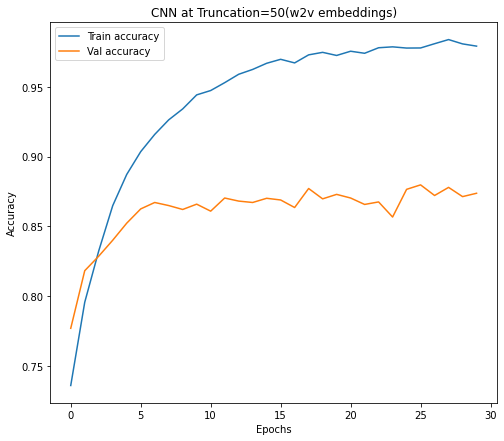

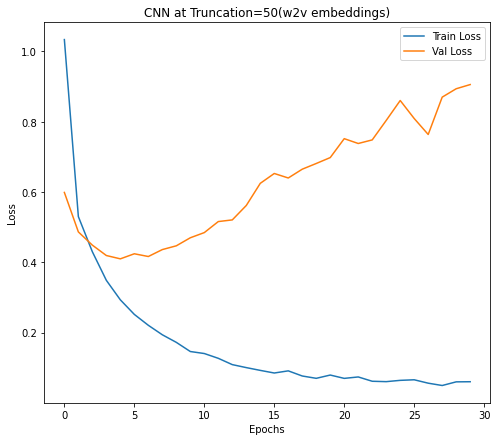

25413/25413 [==============================] - 1s 54us/step
Accuracy at test set with w2v embeddings for CNN at truncation = 50  is:  65.03364443778992
***************************************Bidirectional Lstm at truncation=  50
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_embedding_layer (Embedd (None, None, 50)          1393700   
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 256)         183296    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               164352    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
Dense_layer (Dense)          (None, 32)                4128      
_______________________

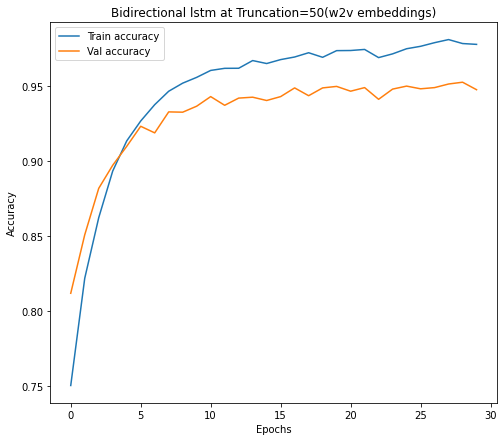

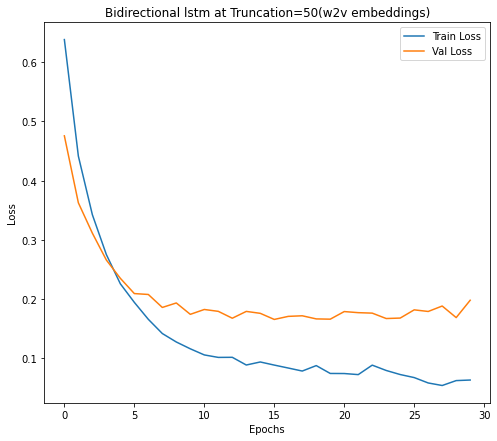

25413/25413 [==============================] - 27s 1ms/step
Accuracy at test set for Bidirectional Lstm with w2v embeddings at truncation = 50  is:  69.63365077972412
*************************************** Lstm at truncation=  50
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_embedding_layer (Embedd (None, None, 50)          1393700   
_________________________________________________________________
lstm_layer_1 (LSTM)          (None, None, 128)         91648     
_________________________________________________________________
lstm_layer_2 (LSTM)          (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
Dense_layer (Dense)          (None, 32)                2080      
_____________________

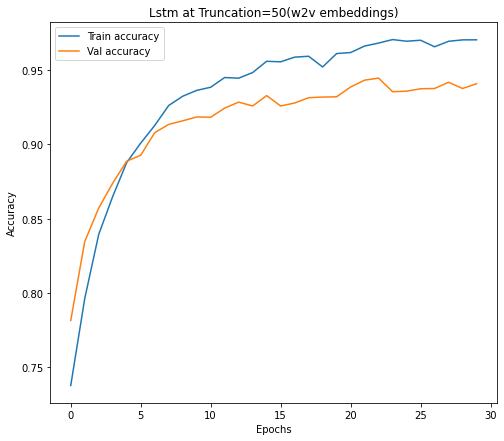

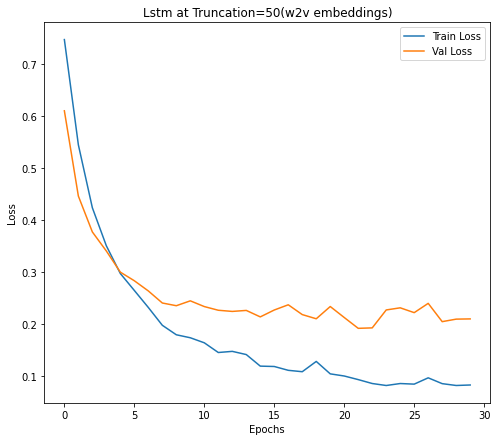

25413/25413 [==============================] - 14s 560us/step
Accuracy at test set with w2v embeddings for Lstm at truncation = 50  is:  70.99515795707703


In [39]:
trunc_n=50   # Best max length given by glove embeddings.. 
X_train,y_train=generate_padded_dataset(combined_head_body_train,tokenizer,full_train,trunc_n)
X_test,y_test=generate_padded_dataset(combined_head_body_test,tokenizer,full_test,trunc_n)

# Encoding labels(train)
# Label Encoder is used to normalize the labels between 0 and N-Classes-1
train_encoder = LabelEncoder()
y_train_encoded=train_encoder.fit_transform(y_train)
# Converting labels to one-hot-encoding
y_train = np_utils.to_categorical(y_train_encoded)

# # Encoding labels(test)
# Label Encoder is used to normalize the labels between 0 and N-Classes-1
test_encoder = LabelEncoder()# predefined function taken from sklearn
y_test_encoded=test_encoder.fit_transform(y_test)
y_test = np_utils.to_categorical(y_test_encoded)
print("y_test shape: ",y_test.shape)
# splitting the dataset
X_train, X_val, y_train, y_val= train_test_split(X_train,y_train, random_state=42, test_size=0.1)


"""
Models | Bi lstm | Lstm | CNN

"""

# CNN 
print("***************************************CNN at truncation= ",trunc_n)

cnn = Sequential()
cnn.add(Embedding(input_dim=len(tokenizer.word_index)+1,output_dim=50,
                          weights = [embedding_matrix_w2v], trainable=False,input_length = trunc_n, name='word_embedding_layer')) # trainable=True results in overfitting

#Con1D layer is taken with 32 filters for feature extraction. 
cnn.add(Conv1D(32, 3, padding='same', activation='relu'))

cnn.add(Flatten())        #Flattened for Dense layer

cnn.add(Dense(256, activation = 'relu'))  #A dense layer with 512 units and relu as activation. 

cnn.add(Dense(4,activation ='softmax'))   #A final fully connected layer. 

print(cnn.summary())

# compiling the model

cnn.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(lr=0.005),
          metrics=['accuracy'])
# Training bidirectional lstm
# get the training history of the model in each epoch
csv_logger = CSVLogger('w2v_training_cnn'+str(trunc_n)+'.log', separator=',', append=False)
cnn_h = cnn.fit(X_train, y_train,batch_size=256,epochs=30,validation_data=(X_val, y_val),callbacks=[csv_logger])

# plots
plots(cnn_h,'CNN at Truncation='+str(trunc_n)+'(w2v embeddings)','w2v_cnn_acc'+str(trunc_n)+'.png','w2v_cnn_loss'+str(trunc_n)+'.png')
# Test accuracy 

score,acc = cnn.evaluate(X_test,y_test)
print("Accuracy at test set with w2v embeddings for CNN at truncation =",trunc_n," is: ",acc*100)

# writing predictions in csv 
pred(X_test,y_test,cnn,'w2v_cnn_'+str(trunc_n)+'.csv')
# print(y_pred.iloc[10:15,:])

keras.backend.clear_session()
del cnn


# Bi lstm 
print("***************************************Bidirectional Lstm at truncation= ",trunc_n)

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1,output_dim=50,
                          weights = [embedding_matrix_w2v], trainable=False, name='word_embedding_layer')) # trainable=True results in overfitting
model.add(Bidirectional(LSTM(128, return_sequences=True, name='Bidrectional_lstm_layer_1')))
model.add(Bidirectional(LSTM(64, return_sequences=False, name='Bidrectional_lstm_layer_2')))

model.add(Dropout(rate=0.4, name='dropout_1'))
model.add(Dense(32,activation='relu', name='Dense_layer'))

model.add(Dropout(rate=0.2, name='dropout_2'))

model.add(Dense(4, activation='softmax', name='output_layer'))

print(model.summary())

# compiling the model

model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(lr=0.005),
          metrics=['accuracy'])
# Training bidirectional lstm
# get the training history of the model in each epoch
csv_logger = CSVLogger('w2v_training_bi_lstm'+str(trunc_n)+'.log', separator=',', append=False)
model_h = model.fit(X_train, y_train,batch_size=256,epochs=30,validation_data=(X_val, y_val),callbacks=[csv_logger])

# plots
plots(model_h,'Bidirectional lstm at Truncation='+str(trunc_n)+'(w2v embeddings)','w2v_bi_lstm_acc'+str(trunc_n)+'.png','w2v_bi_lstm_loss'+str(trunc_n)+'.png')
# Test accuracy 

score,acc = model.evaluate(X_test,y_test)
print("Accuracy at test set for Bidirectional Lstm with w2v embeddings at truncation =",trunc_n," is: ",acc*100)

# writing predictions in csv 
pred(X_test,y_test,model,'w2v_bi_lstm_'+str(trunc_n)+'.csv')

keras.backend.clear_session()
del model
# Base lstm 
print("*************************************** Lstm at truncation= ",trunc_n)

model2 = Sequential()
model2.add(Embedding(input_dim=len(tokenizer.word_index)+1,output_dim=50,
                          weights = [embedding_matrix_w2v], trainable=False, name='word_embedding_layer')) # trainable=True results in overfitting
model2.add(LSTM(128, return_sequences=True, name='lstm_layer_1'))
model2.add(LSTM(64, return_sequences=False, name='lstm_layer_2'))

model2.add(Dropout(rate=0.4, name='dropout_1'))
model2.add(Dense(32,activation='relu', name='Dense_layer'))

model2.add(Dropout(rate=0.2, name='dropout_2'))

model2.add(Dense(4, activation='softmax', name='output_layer'))


print(model2.summary())

# compiling the model

model2.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(lr=0.005),
          metrics=['accuracy'])

# get the training history of the model in each epoch
csv_logger = CSVLogger('w2v_training_lstm'+str(trunc_n)+'.log', separator=',', append=False)
model2_h = model2.fit(X_train, y_train,batch_size=256,epochs=30,validation_data=(X_val, y_val),callbacks=[csv_logger])

# plots
plots(model2_h,'Lstm at Truncation='+str(trunc_n)+'(w2v embeddings)' ,'w2v_lstm_acc'+str(trunc_n)+'.png','w2v_lstm_loss'+str(trunc_n)+'.png')
# Test accuracy 
score,acc = model2.evaluate(X_test,y_test)
print("Accuracy at test set with w2v embeddings for Lstm at truncation =",trunc_n," is: ",acc*100)

# writing predictions in csv 
pred(X_test,y_test,model2,'w2v_lstm_'+str(trunc_n)+'.csv')
# print(y_pred.iloc[10:15,:])

keras.backend.clear_session()
del model2

## Generating plots

In [40]:
cnn_50_history=pd.read_csv('/content/training_cnn50.log')
cnn_100_history=pd.read_csv('/content/training_cnn100.log')
cnn_150_history=pd.read_csv('/content/training_cnn150.log')

lstm_50_history=pd.read_csv('/content/training_lstm50.log')
lstm_100_history=pd.read_csv('/content/training_lstm100.log')
lstm_150_history=pd.read_csv('/content/training_lstm150.log')

bi_lstm_50_history=pd.read_csv('/content/training_bi_lstm50.log')
bi_lstm_100_history=pd.read_csv('/content/training_bi_lstm100.log')
bi_lstm_150_history=pd.read_csv('/content/training_bi_lstm150.log')

# w2v embeddings

w2v_cnn_50_history=pd.read_csv('/content/w2v_training_cnn50.log')
w2v_lstm_50_history=pd.read_csv('/content/w2v_training_lstm50.log')
w2v_bi_lstm_50_history=pd.read_csv('/content/w2v_training_bi_lstm50.log')

### Effect of Truncations

In [41]:
def plots_compare_truncs(model1,model2,model3,title_name,fig_name):
    
    plt.figure(figsize=(8,7))
    
    plt.plot(model1['val_accuracy'])
    plt.plot(model2['val_accuracy'])
    plt.plot(model3['val_accuracy'])
    plt.ylabel('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.title(title_name)
    plt.legend(['Max_length: 50', 'Max_length: 100','Max_length: 150'])
    plt.savefig(fig_name)
    plt.show()

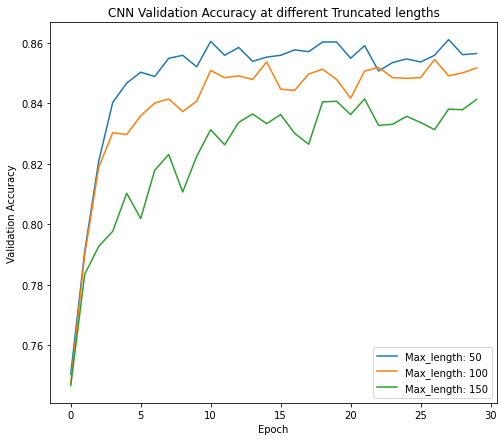

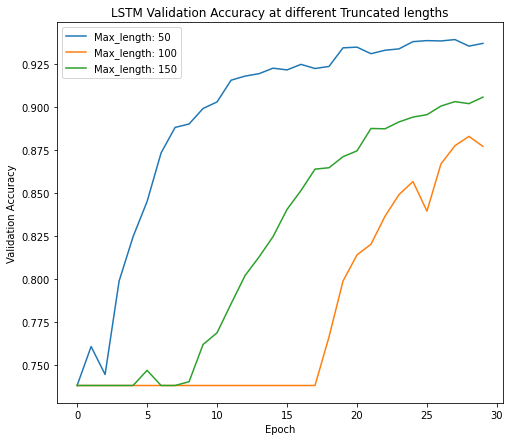

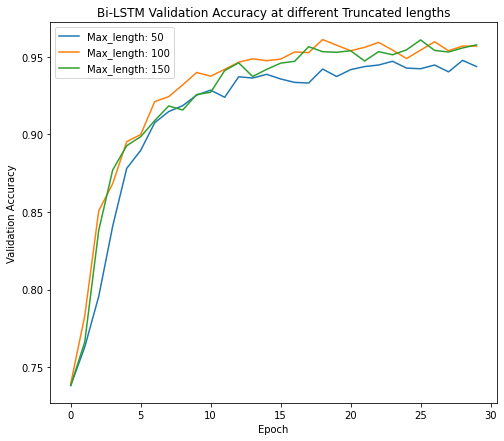

In [42]:
plots_compare_truncs(cnn_50_history,cnn_100_history,cnn_150_history,"CNN Validation Accuracy at different Truncated lengths","CNN_truncations.png")

plots_compare_truncs(lstm_50_history,lstm_100_history,lstm_150_history,"LSTM Validation Accuracy at different Truncated lengths","LSTM_truncations.png")

plots_compare_truncs(bi_lstm_50_history,bi_lstm_100_history,bi_lstm_150_history,"Bi-LSTM Validation Accuracy at different Truncated lengths","Bi_LSTM_truncations.png")


## Loss at different truncated length

In [71]:
def plots_compare_truncs_loss(model1,model2,model3,model4,model5,model6,
                              model7,model8,model9):
    
    
    fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(9,4))
    
    ax[0].plot(model1['val_loss'],label='Max len:50')
    ax[0].plot(model2['val_loss'],label='Max len:100')
    ax[0].plot(model3['val_loss'],label='Max len:150')
    ax[0].legend(loc="upper right")

    ax[1].plot(model4['val_loss'],label='Max len:50')
    ax[1].plot(model5['val_loss'],label='Max len:100')
    ax[1].plot(model6['val_loss'],label='Max len:150')
    ax[1].legend(loc="upper right")

    ax[2].plot(model7['val_loss'],label='Max len:50')
    ax[2].plot(model8['val_loss'],label='Max len:100')
    ax[2].plot(model9['val_loss'],label='Max len:150')
    ax[2].legend(loc="upper right")


    plt.ylabel('Validation Loss')
    plt.xlabel('Epoch')
    
    ax[0].title.set_text('CNN Validation Loss')
    ax[1].title.set_text('LSTM Validation Loss')
    ax[2].title.set_text('Bi-LSTM Validation Loss')
    
    plt.savefig("loss_truncs_subplot.png")
    plt.show()

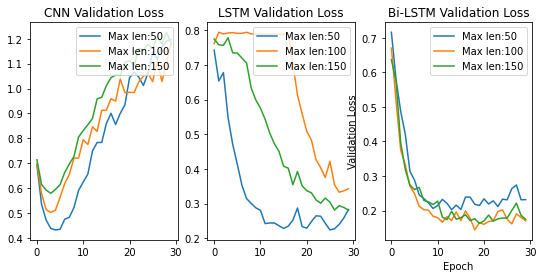

In [72]:
plots_compare_truncs_loss(cnn_50_history,cnn_100_history,cnn_150_history,
                          lstm_50_history,lstm_100_history,lstm_150_history,
                          bi_lstm_50_history,bi_lstm_100_history,bi_lstm_150_history)



### Different Models at best Trunc | accuracy

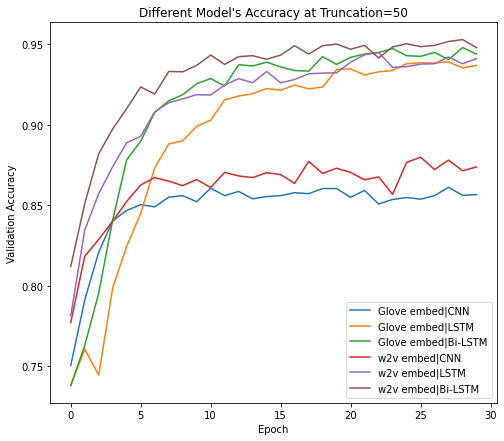

In [43]:
plt.figure(figsize=(8,7))
plt.plot(cnn_50_history['val_accuracy'])
plt.plot(lstm_50_history['val_accuracy'])
plt.plot(bi_lstm_50_history['val_accuracy'])
plt.plot(w2v_cnn_50_history['val_accuracy'])
plt.plot(w2v_lstm_50_history['val_accuracy'])
plt.plot(w2v_bi_lstm_50_history['val_accuracy'])

plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
plt.title("Different Model's Accuracy at Truncation=50")
plt.legend(['Glove embed|CNN', 'Glove embed|LSTM','Glove embed|Bi-LSTM','w2v embed|CNN', 'w2v embed|LSTM','w2v embed|Bi-LSTM'])
plt.savefig("diff_models_best_trunc_acc.png")
plt.show()

### Different Models at best Trunc | Loss

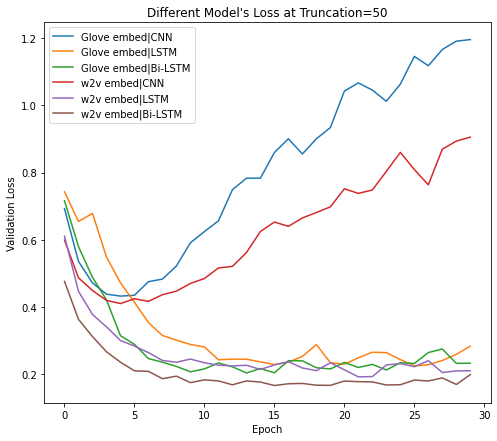

In [44]:
plt.figure(figsize=(8,7))
plt.plot(cnn_50_history['val_loss'])
plt.plot(lstm_50_history['val_loss'])
plt.plot(bi_lstm_50_history['val_loss'])
plt.plot(w2v_cnn_50_history['val_loss'])
plt.plot(w2v_lstm_50_history['val_loss'])
plt.plot(w2v_bi_lstm_50_history['val_loss'])

plt.ylabel('Validation Loss')
plt.xlabel('Epoch')
plt.title("Different Model's Loss at Truncation=50")
plt.legend(['Glove embed|CNN', 'Glove embed|LSTM','Glove embed|Bi-LSTM','w2v embed|CNN', 'w2v embed|LSTM','w2v embed|Bi-LSTM'])
plt.savefig("diff_models_best_trunc_loss.png")
plt.show()